In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from aesara import tensor as at

import pymc_experimental as pmx

In [2]:
from pymc_experimental.gp import HSGP, KarhunenLoeveExpansion, ProjectedProcess
from pymc_experimental.gp.latent_approx import ExpQuad, Matern12, Matern32, Matern52

In [3]:
eta_t = 1.0
ell_t = 1.0
cov_t = eta_t**2 * pm.gp.cov.ExpQuad(1, ls=ell_t)

x = np.linspace(0, 20, 20)
x_cond = np.linspace(0, 20, 100)
x_all = np.concatenate([x, x_cond])
rng = np.random.default_rng(seed=42)
f_all = rng.multivariate_normal(np.zeros(len(x_all)), cov_t(x_all[:, None]).eval(), 1).flatten()
f = f_all[: len(x)]
f_cond_true = f_all[len(x) :]

sigma_t = 0.1
y = f + sigma_t * rng.normal(size=len(x))

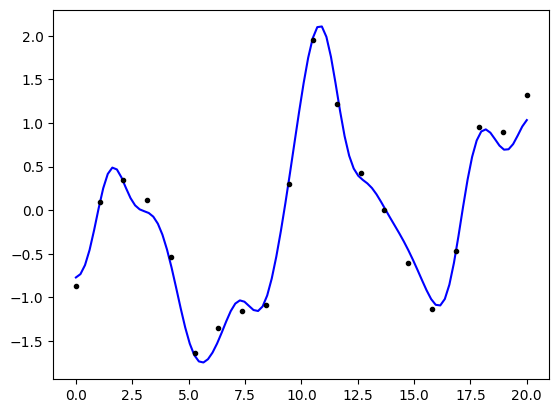

In [4]:
plt.plot(x_cond, f_cond_true, color="b")
plt.plot(x, y, "k.");

# Karhunen Loeve Expansion

In [5]:
%%time

with pm.Model() as model:
    eta = eta_t
    ell = ell_t
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    gp = KarhunenLoeveExpansion(n_eigs=15, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("lik", mu=f, sigma=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [_gp_f_coefs, sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [f_cond]


CPU times: user 3min 12s, sys: 1min 36s, total: 4min 49s
Wall time: 55.5 s


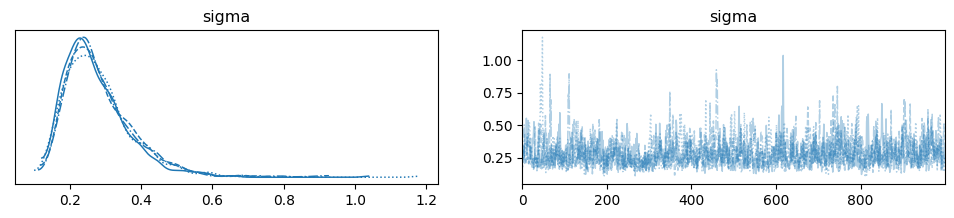

In [6]:
pm.plot_trace(tr, var_names=["sigma"]);

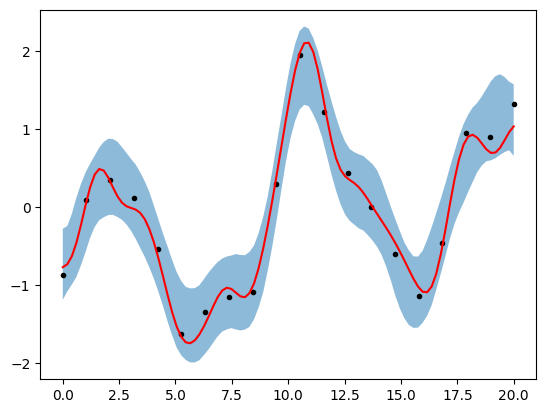

In [7]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
lower0, upper0 = np.percentile(f, [5, 95], axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower0, upper0, alpha=0.5);

# Projected Process / DTC

In [8]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal("eta", sigma=1)
    ell = pm.Gamma("ell", alpha=2, beta=1)
    cov = eta**2 * ExpQuad(1, ls=ell)
    gp = ProjectedProcess(n_inducing=15, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("lik", mu=f, sigma=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ell, f_u_rotated_, sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
Sampling: [f_cond]


CPU times: user 3min 42s, sys: 2min 49s, total: 6min 32s
Wall time: 2min 20s


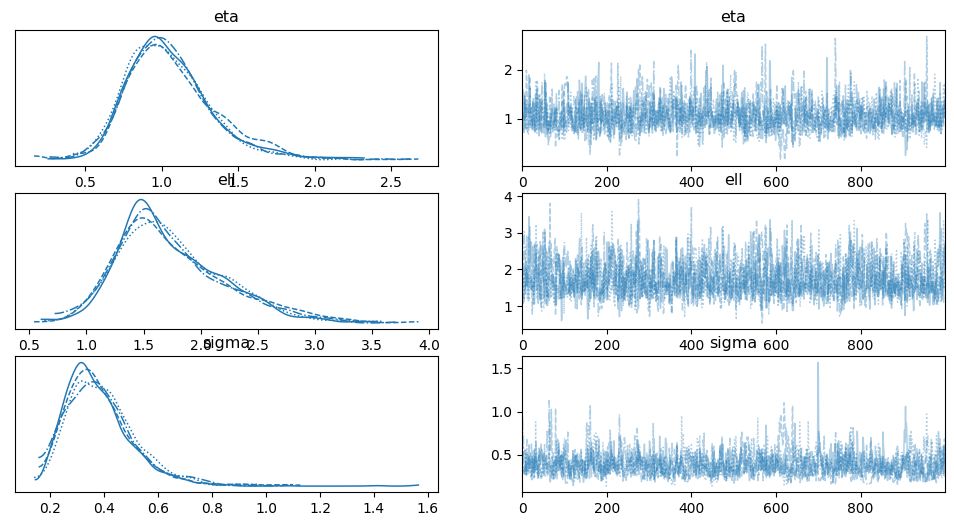

In [9]:
pm.plot_trace(tr, var_names=["eta", "ell", "sigma"]);

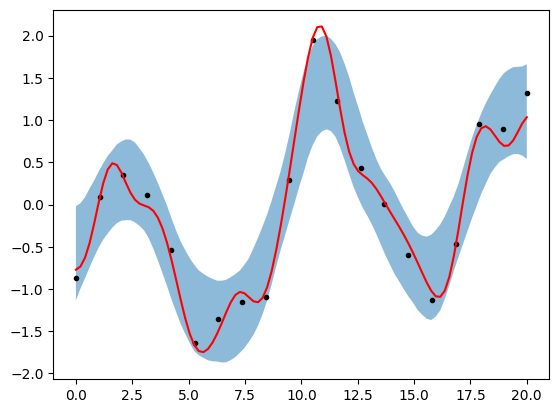

In [10]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
lower1, upper1 = np.percentile(f, [5, 95], axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower1, upper1, alpha=0.5);

# Hilbert Space GP (HSGP)

In [11]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal("eta", sigma=1)
    ell = pm.Gamma("ell", alpha=2, beta=1)
    cov = eta**2 * ExpQuad(1, ls=ell)
    gp = HSGP(n_basis=20, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sigma=1)
    pm.Normal("lik", mu=f, sigma=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ell, f_coeffs_, sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7208, but should be close to 0.9. Try to increase the number of tuning steps.
Sampling: []


CPU times: user 26 s, sys: 556 ms, total: 26.5 s
Wall time: 1min 4s


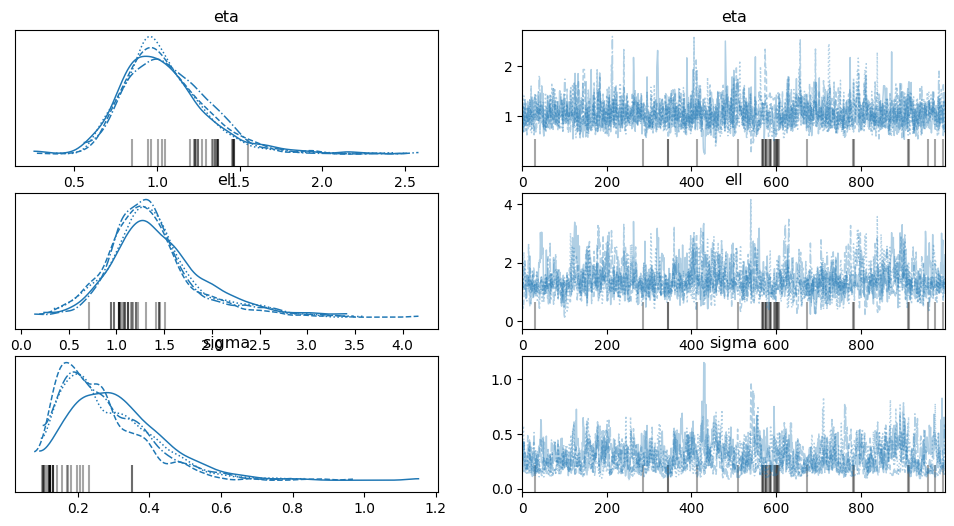

In [12]:
pm.plot_trace(tr, var_names=["eta", "ell", "sigma"]);

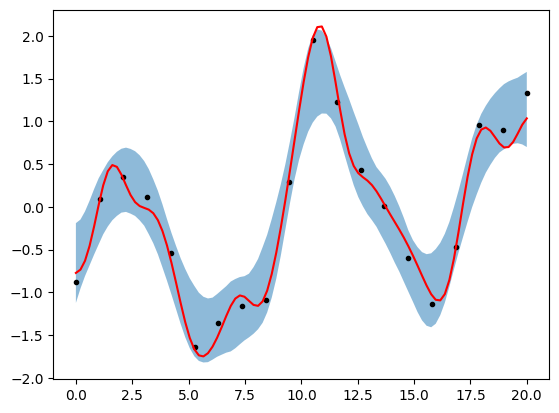

In [13]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
lower2, upper2 = np.percentile(f, [5, 95], axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower2, upper2, alpha=0.5);

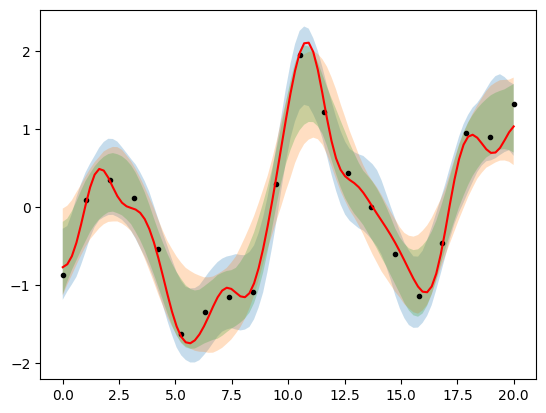

In [15]:
plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower0, upper0, alpha=0.25)
plt.fill_between(x_cond, lower1, upper1, alpha=0.25)
plt.fill_between(x_cond, lower2, upper2, alpha=0.25);